In [1]:
import os
import pims
import torch as tr
import yaml
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path

from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
video = pims.Video(get_project_root() / "resources/test_video.mp4")
video.file = get_project_root() / "resources/test_video.mp4"
print(video.shape, video.frame_rate)

(5395, 720, 1280, 3) 29.97


In [3]:
os.environ["VRE_DEVICE"] = device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict = OmegaConf.load(open(Path.cwd() / "cfg.yaml", "r"))

device = "cuda" if tr.cuda.is_available() else "cpu"

representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[2024-11-11T12:09:03 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:128)
[2024-11-11T12:09:03 VRE-INFO] Building 'depth/dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T12:09:04 VRE-DEBUG] [DepthDpt(depth_dpt)] Setting default 'Learned' params: {'device': 'cuda'} (build_representations.py:build_representation_from_cfg:89)
[2024-11-11T12:09:04 VRE-DEBUG] [DepthDpt(depth_dpt)] Setting default 'Compute' params: {} (build_representations.py:build_representation_from_cfg:102)
[2024-11-11T12:09:04 VRE-DEBUG] [DepthDpt(depth_dpt)] Setting default 'I/O' params: {} (build_representations.py:build_representation_from_cfg:115)
[2024-11-11T12:09:04 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:76)
[2024-11-11T12:09:05 VRE-DEBUG] [Marigold(depth_marigold)] Setting default 'Learned' params: {'device': 'cuda'} (build_representations.

{'depth_dpt': DepthDpt(depth_dpt), 'depth_marigold': Marigold(depth_marigold), 'normals_svd(depth_marigold)': DepthNormalsSVD(normals_svd(depth_marigold) ['depth_marigold'])}


## Run the representations for two particular frame

[2024-11-11T12:12:08 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/depth/marigold/vae.pt' (resources.py:vre_load_weights:73)
[2024-11-11T12:12:09 VRE-DEBUG] Loading weights from '/home/mihai/code/ml/video-representations-extractor/resources/weights/depth/marigold/marigold-lcm-v1-0_unet.pt' (resources.py:vre_load_weights:73)


[2303, 3392]


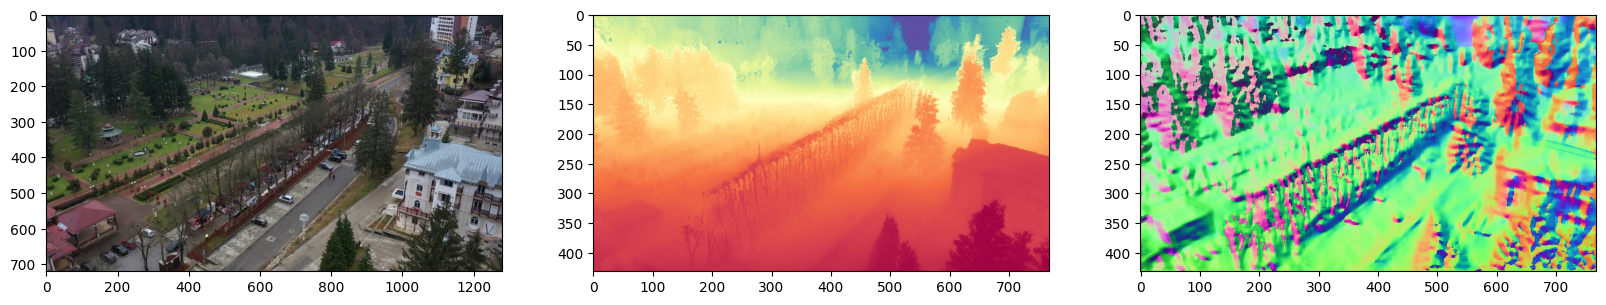

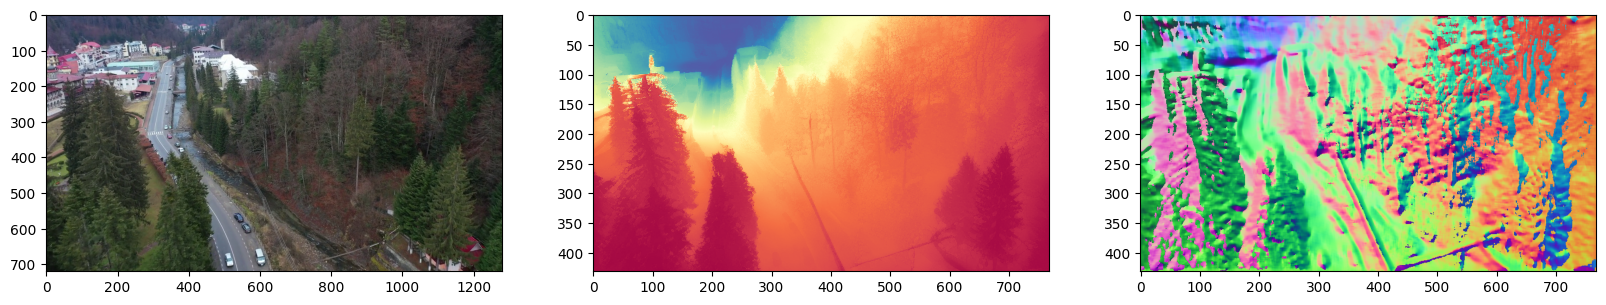

In [9]:
# inference setup (this is done inside VRE's main loop at run() as well)
depth, normals = representations["depth_marigold"], representations["normals_svd(depth_marigold)"]
depth.vre_setup() if depth.setup_called is False else None

np.random.seed(43)
mb = 2
ixs = sorted([np.random.randint(0, len(video) - 1) for _ in range(mb)])
print(ixs)

depth.data = normals.data = None
depth.compute(video, ixs)
y_normals = normals.compute(video, ixs)
y_depth_img = depth.make_images()
y_normals_img = normals.make_images()
for i in range(mb):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(depth.data.frames[i])
    ax[1].imshow(y_depth_img[i])
    ax[2].imshow(y_normals_img[i])
    plt.show()
depth.vre_free()